In [31]:
import numpy as np
import healpy as hp
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
from matplotlib.patches import Ellipse
import matplotlib.cm as cm
% matplotlib inline
plt.style.use('sm')


def get_ang_sep(ra1,dec1,ra2,dec2):
    ra1_rad=ra1*np.pi/180.
    dec1_rad=dec1*np.pi/180.
    ra2_rad=ra2*np.pi/180.
    dec2_rad=dec2*np.pi/180.

    del_ra=ra2_rad-ra1_rad
    del_ras=np.sin(del_ra)
    del_rac=np.cos(del_ra)
    dec1s=np.sin(dec1_rad)
    dec2s=np.sin(dec2_rad)
    dec1c=np.cos(dec1_rad)
    dec2c=np.cos(dec2_rad)

    return (180./np.pi)*np.arctan(np.sqrt((dec2c**2)*(del_ras**2)+(dec1c*dec2s-dec1s*dec2c*del_rac)**2)/(dec1s*dec2s+dec1c*dec2c*del_rac))


/home/cody/python/lib/python2.7/site-packages/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'toolbar', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))


In [13]:
hdulist=fits.open('/DataDisk/datafiles/PGCC_HST/HFI_PCCS_GCC_R2.02.fits')
scidata=hdulist[1].data

In [23]:
ra=328.472074
dec=62.60021
nearest=100.
nearest_pgcc=[]
for pgcc in scidata:
    pgcc_ra=pgcc['ra']
    pgcc_dec=pgcc['dec']
    if abs(pgcc_ra-ra)<1 and abs(pgcc_dec-dec)<1:
        ang_sep=get_ang_sep(ra,dec,pgcc['ra'],pgcc['dec'])
        if ang_sep<nearest:
            nearest=ang_sep
            nearest_pgcc=pgcc
nearest_pgcc

('PGCC G104.08+6.36', 104.078, 6.3585601, 328.66232, 62.567646, 4.7930298, 4.0487399, 4.01336, 4.7930298, 9.2831602, 0.28940201, 7.0465202, 0.221175, 0.80356199, 0.067774497, 0.512604, 0.0, 15.5597, 4.6037698, 5.5696402, 1.75572, 2.19765, 0.57707798, 21.0501, 12.0007, 10.6417, 7.7409501, 4.0412302, 2.6757901, 1.29715, 0.76572901, 2, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.508, 4.5510001, 10.16, 16.038, 24.209999, 7.0079999, 10.695, 24.544001, 1.138, 1.235, 1.007, 3.5, 5.0, 4.664, 13.403, 20.191999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.54000002, 0.44999999, 0.0, 0.0, 0.0, 0.0, 5, 2, 0.54000002, 0.44999999, 5.5263901, 8.1245403, -0.0099983197, -63.3619, -63.3619, 15.65, 78.646103, 78.646103, 1.27045, 1.05799, 0.23015399, -0.79076803, -1.48058, 2.2995901, 3.3480999, 3.9275501, 89.5224, 101.908, -105.867, -827.646, -827.646, 436.616, 1006.68, 1006.68, 1.22394, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.34037e+20, 2.4163501e+20, 9.8523598e+18, -1.77099e+21, 

NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


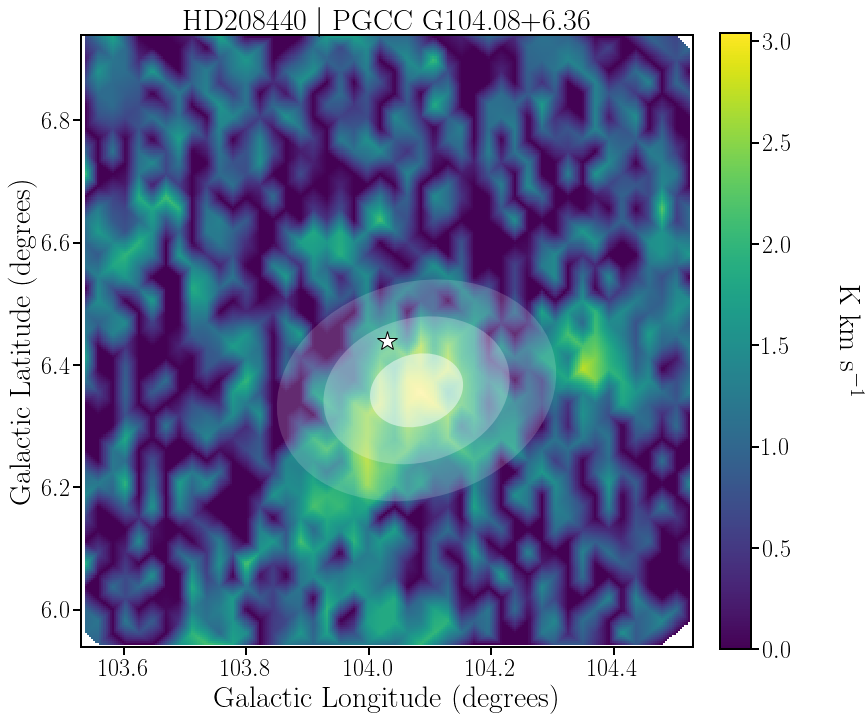

In [54]:
nside=2048
hp_file='/home/cody/python/HFI_CompMap_CO-Type3_2048_R1.10.fits'

glon=104.0297
glat=6.4388
glat=-glat
glon_rad=glon*np.pi/180.
glat_rad=glat*np.pi/180.+(np.pi/2.)

boxsize=1. #degrees
boxsize_rad=boxsize*np.pi/180.
mp=hp.read_map(hp_file)
resol=hp.nside2resol(nside)*180./np.pi
center_pix=hp.ang2pix(nside,glat_rad,glon_rad)

top_left=hp.ang2pix(nside,glat_rad+0.5*boxsize_rad,glon_rad-0.5*boxsize_rad)
top_right=hp.ang2pix(nside,glat_rad+0.5*boxsize_rad,glon_rad+0.5*boxsize_rad)
bot_left=hp.ang2pix(nside,glat_rad-0.5*boxsize_rad,glon_rad-0.5*boxsize_rad)
bot_right=hp.ang2pix(nside,glat_rad-0.5*boxsize_rad,glon_rad+0.5*boxsize_rad)

data=[]
for pix in range(bot_left,top_right):
    if abs(hp.pix2ang(nside,pix)[1]-glon_rad)<boxsize_rad/2.:
        lat,lon=hp.pix2ang(nside,pix)
        intens=mp[pix]
        if intens<0:
            intens=0
        data.append((lon*180./np.pi,-(lat*180./np.pi-90.),np.sqrt(intens)))
        
lons,lats,ints=zip(*data)
lons=np.array(lons)
lats=np.array(lats)
ints=np.array(ints)

thresh=15.
#ints[ints> thresh] = thresh

extent=(glon-(boxsize/2.),glon+(boxsize/2.),-glat-(boxsize/2.),-glat+(boxsize/2.))
xs,ys=np.mgrid[extent[0]:extent[1]:300j,extent[2]:extent[3]:300j]
resampled=griddata(lons,lats,ints,xs,ys,interp='linear')

fig=plt.figure(1,figsize=(12,12))
subplt=plt.subplot(111)
cax=subplt.imshow(resampled.T,extent=extent,cmap=cm.viridis,origin='lower')
subplt.plot(glon,-glat,marker='*',c='w',mec='k',ms=20)

for i in range(1,4):
        ell=Ellipse(xy=(nearest_pgcc['glon'],nearest_pgcc['glat']),width=i*nearest_pgcc['gau_major_axis']/60.,
                    height=i*nearest_pgcc['gau_minor_axis']/60.,angle=-180.*np.pi/nearest_pgcc['gau_position_angle'])
        ell.set_facecolor('w')
        ell.set_alpha(0.5/i)
        subplt.add_patch(ell)

subplt.set_title('HD208440 $|$ PGCC G104.08+6.36',fontsize=30)
subplt.set_xlabel('Galactic Longitude (degrees)',fontsize=30)
subplt.set_ylabel('Galactic Latitude (degrees)',fontsize=30)
cbar=fig.colorbar(cax,fraction=0.046, pad=0.04)
subplt.text(1.25,0.5,'K km s$^{-1}$',transform=subplt.transAxes,ha='center',va='center',rotation=270,fontsize=30)
plt.savefig('/DataDisk/Dropbox/HSTProposal/Cycle25/PGCC/hd208440_map.pdf')